# MSc. Project

### Import Required Modules

In [19]:
import pandas as pd
import numpy as np
import re
import html
from string import punctuation, digits
from sklearn.feature_extraction.text import TfidfVectorizer
from itertools import chain

## Amazon Data

### Reading Amazon Data

In [2]:
AMAZON_DATA_FILE_PATH = "I:\MSc\AmazonData_Ala\meta_Grocery_and_Gourmet_Food_modified.json"
amazon_data = pd.read_json(AMAZON_DATA_FILE_PATH)
print(f"Columns in amazon dataset: {list(amazon_data.columns)}")

Columns in amazon dataset: ['asin', 'description', 'title', 'imUrl', 'related', 'salesRank', 'categories', 'price', 'brand']


### Data Overview

In [3]:
amazon_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171760 entries, 0 to 171759
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   asin         171760 non-null  object 
 1   description  151817 non-null  object 
 2   title        171602 non-null  object 
 3   imUrl        171616 non-null  object 
 4   related      127270 non-null  object 
 5   salesRank    156972 non-null  object 
 6   categories   171760 non-null  object 
 7   price        113152 non-null  float64
 8   brand        63905 non-null   object 
dtypes: float64(1), object(8)
memory usage: 11.8+ MB


In [4]:
amazon_data.head(5)

,asin,description,title,imUrl,related,salesRank,categories,price,brand
0,0657745316,This is real vanilla extract made with only 3 ...,100 Percent All Natural Vanilla Extract,http://ecx.images-amazon.com/images/I/41gFi5h0...,{'also_viewed': ['B001GE8N4Y']},{'Grocery & Gourmet Food': 374004},[[Grocery & Gourmet Food]],NaN,NaN
1,0700026444,"Silverpot Tea, Pure Darjeeling, is an exquisit...",Pure Darjeeling Tea: Loose Leaf,http://ecx.images-amazon.com/images/I/51hs8sox...,NaN,{'Grocery & Gourmet Food': 620307},[[Grocery & Gourmet Food]],NaN,NaN
2,1403796890,Must have for any WWE Fan\n \n \n \nFeaturing ...,WWE Kids Todler Velvet Slippers featuring John...,http://ecx.images-amazon.com/images/I/518SEST5...,NaN,NaN,[[Grocery & Gourmet Food]],3.99,NaN
3,141278509X,Infused with Vitamins and Electrolytes Good So...,Archer Farms Strawberry Dragonfruit Drink Mix ...,http://ecx.images-amazon.com/images/I/51CFQIis...,{'also_viewed': ['B0051IETTY']},{'Grocery & Gourmet Food': 620322},[[Grocery & Gourmet Food]],NaN,NaN
4,1453060375,MiO Energy is your portable energy source givi...,Mio Energy Liquid Water Enhancer Black Cherry ...,http://ecx.images-amazon.com/images/I/51EUsMcn...,"{'also_viewed': ['B006MSEOJ2', 'B005VOOQLO', '...",{'Grocery & Gourmet Food': 268754},[[Grocery & Gourmet Food]],11.99,Mio


In [5]:
amazon_data.isna().sum()

asin                0
description     19943
title             158
imUrl             144
related         44490
salesRank       14788
categories          0
price           58608
brand          107855
dtype: int64

In [6]:
amazon_data["brand"].value_counts()

Unknown                       813
                              798
Trader Joe&#39;s              644
Frontier                      522
Bob&#39;s Red Mill            473
                             ... 
Graceland                       1
fcg                             1
fcw                             1
Tieman&#39;s Fusion Coffee      1
O Kane                          1
Name: brand, Length: 10142, dtype: int64

In [7]:
amazon_data["categories"].value_counts()

[[Grocery & Gourmet Food]]                                                                                                         160346
[[Grocery & Gourmet Food, Beverages, Tea, Tea Samplers]]                                                                              763
[[Grocery & Gourmet Food, Beverages, Tea, Herbal]]                                                                                    583
[[Grocery & Gourmet Food, Beverages, Coffee, Single-Serve Cups]]                                                                      464
[[Grocery & Gourmet Food, Baby Foods, Baby Formula]]                                                                                  324
                                                                                                                                    ...  
[[Grocery & Gourmet Food, Cooking & Baking, Flours & Meals, Corn]]                                                                      1
[[Grocery & Gourmet Food, Beverage

In [8]:
for col in ["title", "description", "brand"]:
    whitespace_chars = amazon_data[col].apply(
        lambda x: set(re.findall(r'\s', str(x))) if x else set()
    ).aggregate({'Whitespace Characters': lambda x: set.union(*x)})
    
    print(f"Whitespace characters found in column: '{col}': {whitespace_chars.values[0]}")

Whitespace characters found in column: 'title': {'\t', '\n', ' '}
Whitespace characters found in column: 'description': {'\t', '\n', ' '}
Whitespace characters found in column: 'brand': {' '}


In [9]:
for col in ["title", "description", "brand"]:
    special_chars = amazon_data[col].apply(lambda x: set(re.findall(r'&\w+', str(x))) if x else set()).aggregate({'Whitespace Characters': lambda x: set.union(*x)})[0]
    print(f"Sample of HTML encoded characters in column: '{col}'")
    print(f"{'HTML Encoded Char':>20} | {'Decoded Char':>20}")
    print("-"*50)
    for ch in list(special_chars)[:5]:
        print(f"{ch.lower(): >20} | {html.unescape(ch.lower()): >20}")

Sample of HTML encoded characters in column: 'title'
   HTML Encoded Char |         Decoded Char
--------------------------------------------------
                &shy |                    ­
              &laquo |                    «
              &szlig |                    ß
               &cent |                    ¢
             &ccedil |                    ç
Sample of HTML encoded characters in column: 'description'
   HTML Encoded Char |         Decoded Char
--------------------------------------------------
             &rsquos |              &rsquos
               &cent |                    ¢
                  &h |                   &h
                  &3 |                   &3
             &beauty |              &beauty
Sample of HTML encoded characters in column: 'brand'
   HTML Encoded Char |         Decoded Char
--------------------------------------------------
              &szlig |                    ß
               &uuml |                    ü
                &uml |

In [10]:
amazon_data["category_count"] = amazon_data["categories"].apply(lambda categories: len(categories))
amazon_data["category_count"].value_counts()

1    171745
2         9
3         3
4         2
6         1
Name: category_count, dtype: int64

In [11]:
amazon_data.drop("category_count", axis=1, inplace=True)

In [12]:
amazon_data.shape, amazon_data.drop_duplicates(subset=["description", "title"]).shape

((171760, 9), (171228, 9))

### Pre-Processing

In [13]:
class ColumnDropper():
    """Given a list of columns, this class is used to drop the columns"""
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self 

    def transform(self, X):
        for column in self.columns:
            if column in X.columns:
                X = X.drop(column, axis=1)
        return X

In [30]:
class RowDropper():
    """Given a list of columns, this class is used to drop rows with NaN in any of the listed columns"""
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        if not self.columns:
            self.columns = X.columns
        return self 

    def transform(self, X):
        X = X.dropna(subset=self.columns, how="any")
        X = X.drop_duplicates(subset=self.columns, keep="last").reset_index(drop=True)
        return X
    

In [15]:
class StringCleaner():
    """
    Given a list of columns, this class is used clean the string in the listed columns with following steps:
            1. Convert string to lower case
            2. Remove HTML encoded characters (characters starting with &)
            3. Remove white spaces
            4. Remove punctuations and digits
            5. Replace empty strings with NaN
    """
    def __init__(self, columns):
        self.columns = columns
        self.translator = str.maketrans('', '', punctuation+digits)
    
    def fit(self, X, y=None):
        return self 
        
    def transform(self, X):
        for column in self.columns:
            # 1. Convert string to lower case
            X[column] = X[column].str.lower()
            
            # 2. Remove HTML encoded characters (characters starting with &)
            X[column] = X[column].apply(lambda s: re.sub('&\w+',' ',str(s)) if not pd.isna(s) else s)
            
            # 3. Remove white spaces
            X[column] = X[column].apply(lambda s: re.sub('\s+',' ',str(s)) if not pd.isna(s) else s)
            
            # 4. Remove punctuations and digits
            X[column] = X[column].apply(lambda s: s.translate(self.translator) if not pd.isna(s) else s)
            
            # 5. Replace empty strings with NaN
            X[column] = X[column].replace('', np.nan)
            X[column] = X[column].replace(' ', np.nan)
        return X
        

In [16]:
# Dropping columns that are not relevant to the project
cd = ColumnDropper(columns=['imUrl', 'related', 'salesRank'])
amazon_data = cd.transform(amazon_data)
amazon_data.shape

(171760, 6)

In [20]:
# Cleaning columns which are string fields
sc = StringCleaner(columns=["description", "title", "brand"])
amazon_data = sc.transform(amazon_data)
amazon_data.head(5)

,asin,description,title,categories,price,brand
0,0657745316,this is real vanilla extract made with only pr...,percent all natural vanilla extract,[[Grocery & Gourmet Food]],NaN,NaN
1,0700026444,silverpot tea pure darjeeling is an exquisite ...,pure darjeeling tea loose leaf,[[Grocery & Gourmet Food]],NaN,NaN
2,1403796890,must have for any wwe fan featuring john cena ...,wwe kids todler velvet slippers featuring john...,[[Grocery & Gourmet Food]],3.99,NaN
3,141278509X,infused with vitamins and electrolytes good so...,archer farms strawberry dragonfruit drink mix ...,[[Grocery & Gourmet Food]],NaN,NaN
4,1453060375,mio energy is your portable energy source givi...,mio energy liquid water enhancer black cherry ...,[[Grocery & Gourmet Food]],11.99,mio


In [31]:
# Dropping rows in which data is missing in crucial fields like 'title', 'description' or are duplicate records
rd = RowDropper(columns=["title", "description"])
amazon_data = rd.transform(amazon_data)
amazon_data.shape

(121891, 6)

In [22]:
# duplicate_desc = amazon_data.groupby("title")["description", "asin", "brand", "price", "categories"].agg({
#                                                    'description': lambda x: ' '.join(x.unique()), 
#                                                    'asin': lambda x: x.iloc[-1],
#                                                    'brand': lambda x: ' '.join(x[~x.isna()].unique()),
#                                                    'price': lambda x: x.mean(),
#                                                    'categories': lambda x: list(chain(x))
#                                                   }).reset_index()

In [33]:
amazon_data = amazon_data.drop_duplicates(subset="description", keep="last").reset_index(drop=True)
amazon_data.shape

(121891, 6)

In [25]:
# Categories are given as a list of list. 
# Therefore, selecting only the first list as it is a list of primary categories of the product
amazon_data["categories"] = amazon_data["categories"].apply(lambda categories: categories[0])

In [26]:
# As this category is mostly required for data visualisation later, this field will not be cleaned any further
amazon_data["categories"].value_counts()

[Grocery & Gourmet Food]                                                                                  112767
[Grocery & Gourmet Food, Beverages, Tea, Tea Samplers]                                                       652
[Grocery & Gourmet Food, Beverages, Tea, Herbal]                                                             503
[Grocery & Gourmet Food, Beverages, Coffee, Single-Serve Cups]                                               324
[Grocery & Gourmet Food, Baby Foods, Baby Formula]                                                           252
                                                                                                           ...  
[Grocery & Gourmet Food, Snack Foods, Cookies, Assortments & Samplers]                                         1
[Grocery & Gourmet Food, Canned, Dry & Packaged Foods, Canned & Jarred Food, Meat & Seafood, Crabmeat]         1
[Grocery & Gourmet Food, Canned, Dry & Packaged Foods, Canned & Jarred Food, Vegetables]        

In [34]:
amazon_data

,asin,description,title,categories,price,brand
0,0657745316,this is real vanilla extract made with only pr...,percent all natural vanilla extract,[Grocery & Gourmet Food],NaN,NaN
1,0700026444,silverpot tea pure darjeeling is an exquisite ...,pure darjeeling tea loose leaf,[Grocery & Gourmet Food],NaN,NaN
2,1403796890,must have for any wwe fan featuring john cena ...,wwe kids todler velvet slippers featuring john...,[Grocery & Gourmet Food],3.99,NaN
3,141278509X,infused with vitamins and electrolytes good so...,archer farms strawberry dragonfruit drink mix ...,[Grocery & Gourmet Food],NaN,NaN
4,1453060375,mio energy is your portable energy source givi...,mio energy liquid water enhancer black cherry ...,[Grocery & Gourmet Food],11.99,mio
...,...,...,...,...,...,...
121886,B00LDOM4OM,you can chew while relaxing at home you can ch...,jessy home green pea snack wasabi peas pack o...,[Grocery & Gourmet Food],NaN,NaN
121887,B00LDXFI6Y,nescafe cafe viet is extracted from the aromat...,nescafe cafe viet vietnamese sweetened instant...,[Grocery & Gourmet Food],17.99,NaN
121888,B00LMMLRG6,moon cheese snacks moon cheese high in protein...,moon cheese oz pack of three assortment,[Grocery & Gourmet Food],16.95,NaN
121889,B00LOXAZ1Q,sour punch candy is the brand of mouth waterin...,sour punch blue raspberry bite ounce bag pe...,[Grocery & Gourmet Food],16.55,NaN


## Ontology Data

In [35]:
ONTOLOGY_DATA_PATH = "I:\MSc\Product Dataset\\"
product_tags = pd.read_csv(ONTOLOGY_DATA_PATH + "product_tags.csv")
preferences = pd.read_csv(ONTOLOGY_DATA_PATH + "preferences.csv")
field_test_preferences = pd.read_csv(ONTOLOGY_DATA_PATH + "field_test_preferences.csv")
preference_tags = pd.read_csv(ONTOLOGY_DATA_PATH + "preference_tags.csv")
preference_to_tags = pd.read_csv(ONTOLOGY_DATA_PATH + "preference_to_tags.csv")
associations = pd.read_csv(ONTOLOGY_DATA_PATH + "associations.csv")
field_test_preferences = field_test_preferences.iloc[:,:-3]

In [36]:
# Filtering data present in the latest version (i.e, not removed from any version)
product_tags = product_tags[product_tags["version removed"]==-1]
preferences = preferences[preferences["version removed"]==-1]
preference_tags = preference_tags[preference_tags["version removed"]==-1]
preference_to_tags = preference_to_tags[preference_to_tags["version removed"]==-1]
associations = associations[associations["version removed"]==-1]

# Dropping 'version removed' column
product_tags.drop("version removed", axis=1, inplace=True)
preferences.drop("version removed", axis=1, inplace=True)
preference_tags.drop("version removed", axis=1, inplace=True)
preference_to_tags.drop("version removed", axis=1, inplace=True)
associations.drop("version removed", axis=1, inplace=True)

In [37]:
summary = pd.DataFrame()
summary["Total No. of Records"] = [product_tags.shape[0], 
                    preferences.shape[0], 
                    field_test_preferences.shape[0], 
                    preference_tags.shape[0], 
                    preference_to_tags.shape[0],
                    associations.shape[0]]
summary["No. of Records (Latest)"] = [product_tags.shape[0], 
                    preferences.shape[0], 
                    field_test_preferences.shape[0], 
                    preference_tags.shape[0], 
                    preference_to_tags.shape[0],
                    associations.shape[0]]
summary["No. of Columns"] = [product_tags.shape[1], 
                    preferences.shape[1], 
                    field_test_preferences.shape[1], 
                    preference_tags.shape[1], 
                    preference_to_tags.shape[1],
                    associations.shape[1]]
summary["Column Names"] = [product_tags.columns.values, 
                    preferences.columns.values, 
                    field_test_preferences.columns.values, 
                    preference_tags.columns.values, 
                    preference_to_tags.columns.values,
                    associations.columns.values]
summary.index = ["product_tags", 
                    "preferences", 
                    "field_test_preferences", 
                    "preference_tags", 
                    "preference_to_tags",
                    "associations"]
summary

,Total No. of Records,No. of Records (Latest),No. of Columns,Column Names
product_tags,196,196,2,"[product tag id, product tag]"
preferences,25,25,2,"[preference id, preference]"
field_test_preferences,25,25,5,"[preference category, preference id, preferenc..."
preference_tags,61,61,2,"[preference tag id, preference tag]"
preference_to_tags,148,148,2,"[preference id, preference tag id]"
associations,795,795,3,"[preference tag id, product tag id, score]"


In [38]:
integrated_data = associations.merge(preference_to_tags, 
                   on="preference tag id", 
                   how="inner").merge(product_tags, 
                                      on="product tag id", 
                                      how="inner").merge(preference_tags, 
                                                         on="preference tag id", 
                                                         how="inner")

In [39]:
integrated_data = field_test_preferences.merge(integrated_data, on="preference id", how="left")

In [40]:
integrated_data.groupby(by=["preference category"]).size()

preference category
E. Environment    353
H. Health         115
Q. Quality         12
S. Social         404
dtype: int64

In [41]:
integrated_data

,preference category,preference id,preference,short id,is strict,preference tag id,product tag id,score,product tag,preference tag
0,E. Environment,176,1. Products disposed in an environmentally fri...,E.1,False,37,1336,0.991,egg organic,biodegradeable
1,E. Environment,176,1. Products disposed in an environmentally fri...,E.1,False,37,1337,0.991,egg free range,biodegradeable
2,E. Environment,176,1. Products disposed in an environmentally fri...,E.1,False,37,1338,0.991,egg barn,biodegradeable
3,E. Environment,176,1. Products disposed in an environmentally fri...,E.1,False,37,1339,0.991,egg enriched cages,biodegradeable
4,E. Environment,176,1. Products disposed in an environmentally fri...,E.1,False,37,1323,-0.951,packaging label A,biodegradeable
...,...,...,...,...,...,...,...,...,...,...
879,S. Social,196,6. Products from fair trade label companies,S.6,False,76,1397,-0.250,organization/label tag 61,land
880,S. Social,196,6. Products from fair trade label companies,S.6,False,76,1398,-0.620,organization/label tag 63,land
881,S. Social,196,6. Products from fair trade label companies,S.6,False,76,1399,-0.070,organization/label tag 64,land
882,S. Social,196,6. Products from fair trade label companies,S.6,False,76,1400,0.290,organization/label tag 66,land


In [42]:
ontology_data = integrated_data.loc[~((integrated_data['product tag'].str.contains("organization")) 
                                      | (integrated_data['product tag'].str.contains("packaging")))].reset_index(drop=True)
ontology_data = ontology_data[["product tag id", "product tag", 
          "preference tag id", "preference tag", "score", 
          "preference id", "preference", "preference category", "short id", "is strict"]]

In [43]:
sc = StringCleaner(["product tag", "preference tag"])
ontology_data = sc.transform(ontology_data)

In [44]:
integrated_data.groupby(by=["preference category", "preference"]).size().reset_index()["preference category"].value_counts()

H. Health         13
S. Social          6
E. Environment     3
Q. Quality         3
Name: preference category, dtype: int64

In [45]:
ontology_data.groupby(by=["preference category", "preference"]).size().reset_index()["preference category"].value_counts()

H. Health         13
S. Social          5
E. Environment     3
Q. Quality         3
Name: preference category, dtype: int64

In [46]:
integrated_data[~integrated_data["preference"].isin(ontology_data["preference"].unique())]["preference"].unique()[0]

'1. Products evaluated with auditing processes that rely on sustainability criteria.'

In [47]:
ontology_data

,product tag id,product tag,preference tag id,preference tag,score,preference id,preference,preference category,short id,is strict
0,1336,egg organic,37,biodegradeable,0.991,176,1. Products disposed in an environmentally fri...,E. Environment,E.1,False
1,1337,egg free range,37,biodegradeable,0.991,176,1. Products disposed in an environmentally fri...,E. Environment,E.1,False
2,1338,egg barn,37,biodegradeable,0.991,176,1. Products disposed in an environmentally fri...,E. Environment,E.1,False
3,1339,egg enriched cages,37,biodegradeable,0.991,176,1. Products disposed in an environmentally fri...,E. Environment,E.1,False
4,1354,egg origin estonia,37,biodegradeable,0.991,176,1. Products disposed in an environmentally fri...,E. Environment,E.1,False
...,...,...,...,...,...,...,...,...,...,...
316,1425,proactive supply chain investigation,75,transparency,0.200,194,5. Products from companies with transparent ac...,S. Social,S.5,False
317,1354,egg origin estonia,41,fair trade,0.100,196,6. Products from fair trade label companies,S. Social,S.6,False
318,1514,very transparent company,41,fair trade,0.300,196,6. Products from fair trade label companies,S. Social,S.6,False
319,1515,transparent company,41,fair trade,0.100,196,6. Products from fair trade label companies,S. Social,S.6,False


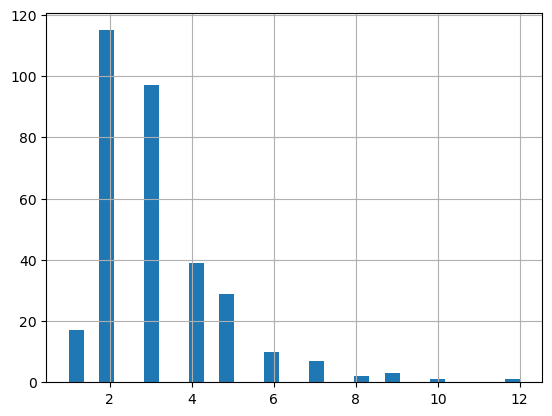

In [48]:
word_count = ontology_data["product tag"].apply(lambda s: len(s.strip().split()))
axes = word_count.hist(bins=30)

In [130]:
ontology_data[~ontology_data["product tag"].str.contains("free")]

,product tag id,product tag,preference tag id,preference tag,score,preference id,preference,preference category,short id,is strict
0,1336,egg organic,37,biodegradeable,0.991,176,1. Products disposed in an environmentally fri...,E. Environment,E.1,False
2,1338,egg barn,37,biodegradeable,0.991,176,1. Products disposed in an environmentally fri...,E. Environment,E.1,False
3,1339,egg enriched cages,37,biodegradeable,0.991,176,1. Products disposed in an environmentally fri...,E. Environment,E.1,False
4,1354,egg origin estonia,37,biodegradeable,0.991,176,1. Products disposed in an environmentally fri...,E. Environment,E.1,False
5,1366,fresh made in store,37,biodegradeable,0.500,176,1. Products disposed in an environmentally fri...,E. Environment,E.1,False
...,...,...,...,...,...,...,...,...,...,...
316,1425,proactive supply chain investigation,75,transparency,0.200,194,5. Products from companies with transparent ac...,S. Social,S.5,False
317,1354,egg origin estonia,41,fair trade,0.100,196,6. Products from fair trade label companies,S. Social,S.6,False
318,1514,very transparent company,41,fair trade,0.300,196,6. Products from fair trade label companies,S. Social,S.6,False
319,1515,transparent company,41,fair trade,0.100,196,6. Products from fair trade label companies,S. Social,S.6,False


In [132]:
ontology_data[ontology_data["preference id"]==190]

,product tag id,product tag,preference tag id,preference tag,score,preference id,preference,preference category,short id,is strict
115,1280,allergen nuts,73,allergen free,-1.0,190,1. Allergen-free products,H. Health,H.1,False
116,1281,allergen soybeans and products thereof,73,allergen free,-1.0,190,1. Allergen-free products,H. Health,H.1,False
117,1342,allergens peanuts and products thereof,73,allergen free,-1.0,190,1. Allergen-free products,H. Health,H.1,False
118,1348,allergens fish and products thereof,73,allergen free,-1.0,190,1. Allergen-free products,H. Health,H.1,False
119,1349,allergens eggs and products thereof,73,allergen free,-1.0,190,1. Allergen-free products,H. Health,H.1,False
120,1340,lactose free,73,allergen free,0.4,190,1. Allergen-free products,H. Health,H.1,False
121,1341,cholesterol free,73,allergen free,0.4,190,1. Allergen-free products,H. Health,H.1,False
122,1343,allergens celery and products thereof,73,allergen free,-1.0,190,1. Allergen-free products,H. Health,H.1,False
123,1344,allergens mustard seeds and products thereof,73,allergen free,-1.0,190,1. Allergen-free products,H. Health,H.1,False
124,1345,allergens sesame seeds and products thereof,73,allergen free,-1.0,190,1. Allergen-free products,H. Health,H.1,False


## Keyword Extraction

In [108]:
tfidf = TfidfVectorizer(ngram_range=(2,3), stop_words='english')

In [109]:
products_tfidf = tfidf.fit_transform(ontology_data["product tag"])
products_tfidf

<321x297 sparse matrix of type '<class 'numpy.float64'>'
	with 790 stored elements in Compressed Sparse Row format>

In [110]:
desc_tfidf = tfidf.transform(amazon_data["description"])
desc_tfidf

<121891x297 sparse matrix of type '<class 'numpy.float64'>'
	with 9630 stored elements in Compressed Sparse Row format>

In [111]:
df_desc=pd.DataFrame()
for i, col in enumerate(tfidf.get_feature_names_out()):
    df_desc[col] = pd.Series(pd.arrays.SparseArray(desc_tfidf[:, i].toarray().ravel()))

In [112]:
df_desc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121891 entries, 0 to 121890
Columns: 297 entries, allergen nuts to weak anti deforestation
dtypes: Sparse[float64, nan](297)
memory usage: 414.3 MB


In [113]:
print(f"Number of descriptions with zero keywords in the vocab: {df_desc[df_desc.sum(axis=1)==0].shape[0]} out of {df_desc.shape[0]}")

Number of descriptions with zero keywords in the vocab: 113337 out of 121891


In [114]:
(df_desc>0).sum(axis=1).sort_values(ascending=False)

8872      5
1366      5
28789     5
47860     5
25169     5
         ..
41989     0
41988     0
41987     0
41986     0
121890    0
Length: 121891, dtype: int64

In [116]:
df_desc.iloc[8872][df_desc.iloc[8872]>0]

cholesterol free    0.467777
contains animal     0.414460
gluten free         0.467777
low fat             0.467777
saturated fats      0.414460
Name: 8872, dtype: Sparse[float64, nan]

In [117]:
product = np.dot(desc_tfidf, products_tfidf.T)
product.shape

(121891, 321)

In [118]:
df_product=pd.DataFrame()
for i in range(product.shape[1]):
    df_product[i] = pd.Series(pd.arrays.SparseArray(product[:, i].toarray().ravel()))
df_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121891 entries, 0 to 121890
Columns: 321 entries, 0 to 320
dtypes: Sparse[float64, nan](321)
memory usage: 447.8 MB


In [119]:
df_product

,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,320
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
121887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
121888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
121889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [137]:
(df_product>0).sum(axis=1).sort_values(ascending=False)

26241     19
35502     19
51818     19
83533     19
98903     18
          ..
41989      0
41988      0
41987      0
41986      0
121890     0
Length: 121891, dtype: int64

In [138]:
sample = (df_product>0).sum(axis=1).sort_values(ascending=False)[:5].index
df_product.iloc[sample][df_product.iloc[sample]>0]#.sort_values(ascending=False)

,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,320
26241,NaN,0.255105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35502,NaN,0.209016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51818,NaN,0.209016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83533,NaN,0.255105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98903,NaN,0.164968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
ontology_data.iloc[df_product.iloc[26241][df_product.iloc[26241]>0].sort_values(ascending=False).index]

,product tag id,product tag,preference tag id,preference tag,score,preference id,preference,preference category,short id,is strict
152,1373,gluten free,44,gluten free,0.991,179,2. Gluten-free products,H. Health,H.2,True
117,1342,allergens peanuts and products thereof,73,allergen free,-1.000,190,1. Allergen-free products,H. Health,H.1,False
160,1342,allergens peanuts and products thereof,45,high protein,0.010,181,3. High-protein products,H. Health,H.3,False
157,1337,egg free range,45,high protein,0.100,181,3. High-protein products,H. Health,H.3,False
285,1337,egg free range,74,factory farming,-0.100,195,3. Products from companies that support animal...,S. Social,S.3,False
265,1337,egg free range,28,vegan,-1.000,195,3. Products from companies that support animal...,S. Social,S.3,False
254,1337,egg free range,55,green farming,0.500,195,3. Products from companies that support animal...,S. Social,S.3,False
243,1337,egg free range,42,animal rights,0.600,195,3. Products from companies that support animal...,S. Social,S.3,False
215,1337,egg free range,29,vegetarian,0.991,189,13. Vegetarian products,H. Health,H.13,True
195,1337,egg free range,28,vegan,-1.000,188,12. Vegan products,H. Health,H.12,True


In [139]:
amazon_data.iloc[35502]["description"]

'glee gum all natural chewing gum tangerine pieces glee gum all natural chewing gum tangerine is an allnatural ecofriendly chewing gum made with sustainably harvested rainforest chicle glee gum is the healthy alternative to synthetic chewing gum and bubble gum no artificial colors flavors preservatives or sweeteners no aspartame saccharin or cyclamate chew with glee naturally all glee gum is vegetarian gmo free additive free dairy free wheat free gluten free egg free yeast free nut free and peanut free glee gum is the only gum on the market which contains chicle in its gum base and using chicle helps sustain the rainforest frequently asked questions what makes glee gum specialglee gum is natural chewing gum made without preservatives artificial flavorings colorings or sweeteners no aspartame it is also the only gum on the market that contains chicle in its gum base and using chicle helps sustain the rainforest what is chiclechicle is the sap from the sapodilla pronounced sapohdeeyah tr

In [140]:
df_desc.iloc[35502][df_desc.iloc[35502]>0]

allergens milk     0.550136
contains gluten    0.513457
egg free           0.362026
gluten free        0.550136
Name: 35502, dtype: Sparse[float64, nan]